resources: 

* [DQN Atari Space Invaders](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb) (Deep Reinforcement Learning Course)

* [Reinforcement Learning](https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb) (Hands-On ML)

* [Deep Q Learning](https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb) (Udacity)

In [54]:
import tensorflow as tf
import numpy as np        
import gym                

from skimage import transform 
from skimage.color import rgb2gray 

import matplotlib.pyplot as plt 
import matplotlib.animation as animation
%matplotlib nbagg

from collections import deque

In [36]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [2]:
env = gym.make("Pong-v0")

In [23]:
print("The size of our frame is: ", env.observation_space)
print("The action size is : ", env.action_space.n)

The size of our frame is:  Box(210, 160, 3)
The action size is :  6


<IPython.core.display.Javascript object>


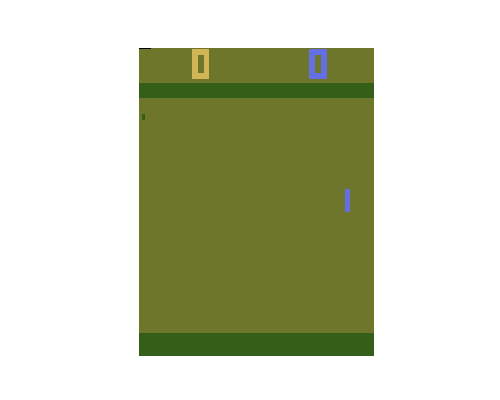

In [40]:
plot_environment(env)

## Preprocessing

### Grayscale and Cropping

In [51]:
def preprocess_frame(frame):
    # Greyscale frame 
    copy = np.copy(frame)
    
    gray = rgb2gray(copy)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[32:195,:]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    preprocessed_frame = transform.resize(cropped_frame, [90,90], mode='constant')
    
    return preprocessed_frame # 110x84x1 frame

<IPython.core.display.Javascript object>


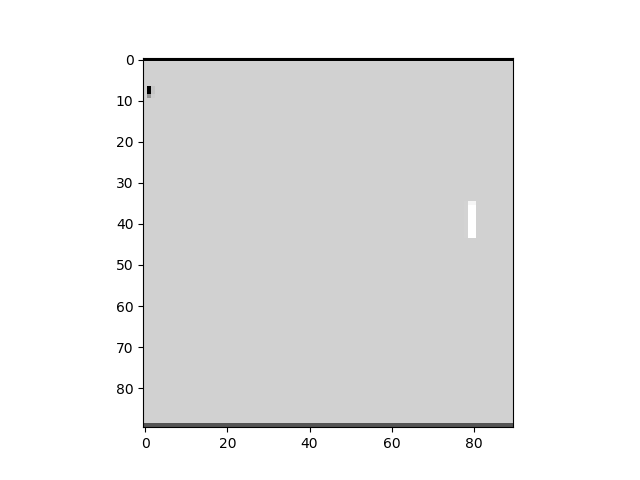

In [52]:
pre = preprocess_frame(env.render(mode="rgb_array"))
plt.close()
plt.imshow(pre, cmap='gray');

### Stacking Frames

In [55]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((90,90), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

## Hyperparameters

In [57]:
### MODEL HYPERPARAMETERS
state_size = [110, 84, 4]        # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels) 
action_size = env.action_space.n # 8 possible actions
learning_rate =  0.00025         # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 50              # Total episodes for training
max_steps = 50000                # Max possible steps in an episode
batch_size = 64                  # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0              # exploration probability at start
explore_stop = 0.01              # minimum exploration probability 
decay_rate = 0.00001             # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                      # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size     # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000            # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                   # Number of frames stacked

## Build Model

## Experience Replay

In [56]:
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Train Agent

## Evaluate Agent